<a href="https://colab.research.google.com/github/leoclementliao/colab-yolov3/blob/master/yolov3_s2_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!/opt/bin/nvidia-smi

Mon Apr 13 15:55:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
## Download yolov3 weight
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights

--2020-04-13 20:15:43--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights  53%[=========>          ] 127.16M   365KB/s    eta 5m 53s 

In [2]:
## git yolo3_tf2 and pip libraries
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt

## Copy tfrecord dataset
% cp -r /content/drive/My\ Drive/Colab\ Notebooks/YoloV3/data /content/yolov3-tf2/data

## Download yolov3 weight (12 minutes)
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 341, done.
remote: Total 341 (delta 0), reused 0 (delta 0), pack-reused 341
Receiving objects: 100% (341/341), 4.16 MiB | 6.51 MiB/s, done.
Resolving deltas: 100% (198/198), done.
/content/yolov3-tf2
Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 421.8MB 34kB/s 
     |████████████████████████████████| 28.7MB 117kB/s 
     |████████████████████████████████| 450kB 50.4MB/s 
     |████████████████████████████████| 3.9MB 46.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=abf53c53773ce40e273d404071550569e1b4a1a226f63d870a81bd122e01e02a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorboard<2.3

In [3]:
## Dataset directory
train_dir = '/content/yolov3-tf2/data/data/voc2009_train.tfrecord'
val_dir = '/content/yolov3-tf2/data/data/voc2009_val.tfrecord'

## Load class names
class_names = []
with open("/content/yolov3-tf2/data/data/voc2009.name", "r") as f:
    for s in f:
        class_names.append(s[:-1])

num_classes = len(class_names)
print(f'{num_classes} classes')


20 classes


In [7]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

['yolov3']

In [0]:
yolo = YoloV3(classes=num_classes)

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Model)            ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, None, None, 5 11024384    yolo_darknet[1][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, None, None, 2 2957312     yolo_conv_0[1][0]                
                                                                 yolo_darknet[1][1]          

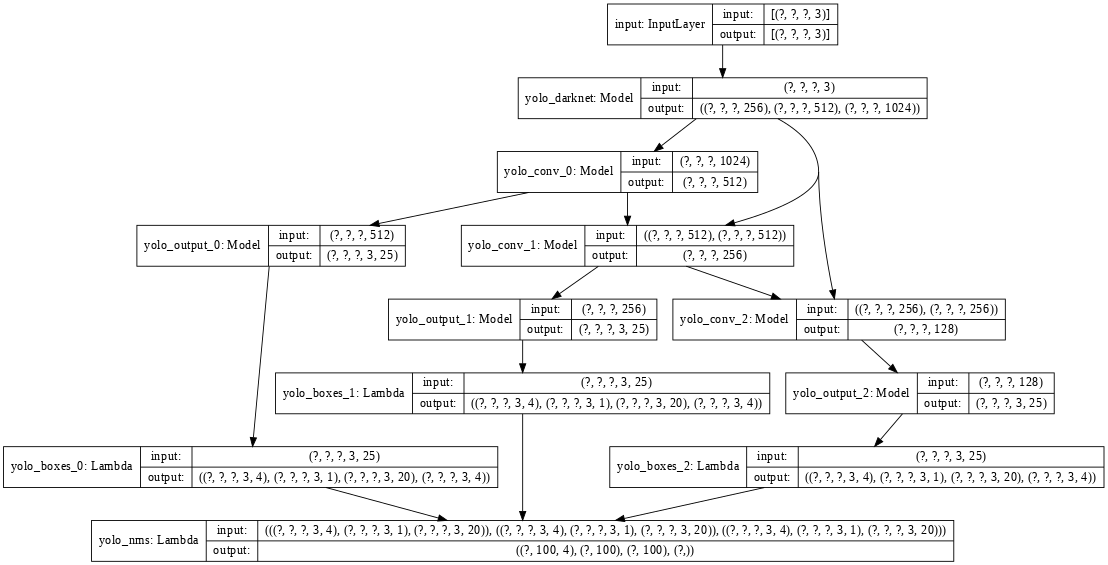

In [9]:
yolo.summary()
tf.keras.utils.plot_model(yolo, show_shapes=True, dpi=64)

In [0]:
## Training parameters
epochs = 2
batch_size = 8
learning_rate = 1e-3
image_size = 416
weights_dir = '/content/yolov3-tf2/data/yolov3.weights'
